# Lab 6: Random Forest Regression on Malagasy Mammal Traits

### Introduction
 In Lab 5, we used functional trait data on bird species to predict their presence in a given climate type. This week we are using regression tree models on a similar dataset, this one on mammal species.  Our goal is to predict the total number of climate types each mammal species inhabits.

You will compare performance of a single decision tree with a tuned random forest to get a sense of the effectiveness of ensemble methods with optimized hyperparameter values.

There is a fair amount of missing data in this set, which can lead to low reliability of feature splits, increased overfitting, and decreased accuracy of tree models. You will address this issue with a combination of variable omission and imputation.


In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

### Step 1: Read data and retain a subset of the columns
Similar to last week, we will need to take some steps to get the data in a usable form. We again reformat the diet-related variable names to match this set: `Diet_Vertebrates`,
    `Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`. Then drop columns that are not relevant functional traits or climate type variables.   Next, drop any remaining  variables that have greater than 40% of the observations missing. Print the final dataframe shape. 

In [51]:
dat = pd.read_csv("data/MamTraitData.csv", encoding="ISO-8859-1", na_values=-999).rename(columns={
    'Diet: invertebrates': 'Diet_Invertebrates',
    'Diet: vertebrates': 'Diet_Vertebrates',
    'Diet: fruits': 'Diet_Fruits',
    'Diet: flower/nectar/pollen/gums': 'Diet_Flowers',
    'Diet: seeds': 'Diet_Seeds',
    'Diet: other plant materials': 'Diet_Plants',
    'Diet: scavenge; garbage; carrion; offal; carcasses': 'Diet_Other'
})

# Drpo remaining variables that have >40% observations missing
features = dat.loc[:, dat.isnull().mean() <= .4]

#print(f"Final DataFrame shape: ")
print(f"Final DataFrame shape: {features.shape}")

Final DataFrame shape: (214, 17)


In [52]:
dat.head()

,AdultBodyMass,CranialCapacity,Diet_Invertebrates,Diet_Vertebrates,Diet_Fruits,Diet_Flowers,Diet_Seeds,Diet_Plants,Diet_Other,HabitatBreadth,...,InterbirthInterval,HomeRange,PopulationDensity,SocialGrpSize,Longevity,Dry,Humid,Montane,Subarid,Subhumid
0,78.0,NaN,yes,no,yes,yes,no,yes,no,1.0,...,365.0,10.40,18.00,1.0,107.8,0,1,1,0,1
1,1082.0,NaN,no,no,yes,no,no,yes,no,1.0,...,NaN,NaN,NaN,NaN,NaN,0,1,0,0,1
2,946.0,NaN,no,no,yes,no,no,yes,no,2.0,...,NaN,0.02,NaN,NaN,NaN,1,0,0,0,0
3,1180.0,10.0,no,no,yes,no,no,yes,no,2.0,...,365.0,0.01,84.85,2.0,NaN,1,1,1,0,1
4,1212.5,NaN,no,no,yes,no,no,yes,no,1.0,...,NaN,NaN,114.00,NaN,NaN,0,1,0,1,1


In [53]:
features.isna().sum()

AdultBodyMass          3
Diet_Invertebrates    15
Diet_Vertebrates      15
Diet_Fruits           15
Diet_Flowers          15
Diet_Seeds            15
Diet_Plants           15
Diet_Other            15
HabitatBreadth        26
ActivityCycle         22
ForagingStratum       24
LitterSize            83
Dry                    0
Humid                  0
Montane                0
Subarid                0
Subhumid               0
dtype: int64

### Step 2: Imputation with KNN
Now impute the values of the missing data in the remaining numeric columns using k-nearest neighbors with `KNNImputer()`. Use the 5 nearest neighbors. This allows us to implement the knn algorithm to predict the missing values for an observation based on similar complete observations.Perform and print a check to ensure that there are no more NA values. 

In [54]:
features_impute = features.copy()

# Separate numerical and categorical features
numerical_features = features_impute.select_dtypes(include=['number']).columns
categorical_features = features_impute.select_dtypes(exclude=['number']).columns

# Apply KNN imputation for numerical features
knn_impute = KNNImputer(n_neighbors=5)
features_impute[numerical_features] = knn_impute.fit_transform(features_impute[numerical_features])

# Apply mode imputation for categorical features
# Impute with mode
features_impute[categorical_features] = features_impute[categorical_features].fillna(features_impute[categorical_features].mode().iloc[0])

# Check to make sure there are no NAs
features_impute.isna().sum()

AdultBodyMass         0
Diet_Invertebrates    0
Diet_Vertebrates      0
Diet_Fruits           0
Diet_Flowers          0
Diet_Seeds            0
Diet_Plants           0
Diet_Other            0
HabitatBreadth        0
ActivityCycle         0
ForagingStratum       0
LitterSize            0
Dry                   0
Humid                 0
Montane               0
Subarid               0
Subhumid              0
dtype: int64

In [55]:
features_impute.head()

,AdultBodyMass,Diet_Invertebrates,Diet_Vertebrates,Diet_Fruits,Diet_Flowers,Diet_Seeds,Diet_Plants,Diet_Other,HabitatBreadth,ActivityCycle,ForagingStratum,LitterSize,Dry,Humid,Montane,Subarid,Subhumid
0,78.0,yes,no,yes,yes,no,yes,no,1.0,2.0,3.0,1.000,0.0,1.0,1.0,0.0,1.0
1,1082.0,no,no,yes,no,no,yes,no,1.0,1.0,3.0,1.402,0.0,1.0,0.0,0.0,1.0
2,946.0,no,no,yes,no,no,yes,no,2.0,1.0,3.0,4.692,1.0,0.0,0.0,0.0,0.0
3,1180.0,no,no,yes,no,no,yes,no,2.0,1.0,3.0,1.010,1.0,1.0,1.0,0.0,1.0
4,1212.5,no,no,yes,no,no,yes,no,1.0,1.0,3.0,1.540,0.0,1.0,0.0,1.0,1.0


### Step 3: Create target variable and numerical encoding 
Create the target variable (`nClimates`) representing the  number of climates in which a species was present. Then finish preparing the data to be used in our models.

- Create a new column `nClimates` that combines the information of the five climate type variables
- Drop the original `Dry`, `Humid`, `Montane`, `Subarid`, and `Subhumid` columns
- Encode categorical variables
- Split the dataset into training and test sets. Use a random state of 808. 

In [56]:
target_features = ['Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid']

features = features_impute.copy()

features["nClimates"] = dat[target_features].sum(axis=1)
features = features.drop(columns=target_features, axis=1)


categorical_features = features.select_dtypes(exclude=['number']).columns

# Factorize all columns 
for col in categorical_features:
    features.loc[:,col] = pd.factorize(features[col], sort = True)[0]

X = features.drop("nClimates", axis=1)
y = features["nClimates"]
    
# Split actual data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=808)

In [57]:
features.head()

,AdultBodyMass,Diet_Invertebrates,Diet_Vertebrates,Diet_Fruits,Diet_Flowers,Diet_Seeds,Diet_Plants,Diet_Other,HabitatBreadth,ActivityCycle,ForagingStratum,LitterSize,nClimates
0,78.0,1,0,1,1,0,1,0,1.0,2.0,3.0,1.000,3
1,1082.0,0,0,1,0,0,1,0,1.0,1.0,3.0,1.402,2
2,946.0,0,0,1,0,0,1,0,2.0,1.0,3.0,4.692,1
3,1180.0,0,0,1,0,0,1,0,2.0,1.0,3.0,1.010,4
4,1212.5,0,0,1,0,0,1,0,1.0,1.0,3.0,1.540,3


### Step 4: Train a decision tree
Train a single decision tree to predict the number of climate types inhabited by each species.

- Train a `DecisionTreeRegressor`.  Let's apply a constraint on its growth by not allowing the tree to grow further than 5 levels. Use a random state of 808. 
- Make predictions
- Visualize the decision tree using `plot_tree`
- Evaluate and print its performance using mse

In [58]:
# Initialize Decision Tree Regressor model
DTR = DecisionTreeRegressor(max_depth=5, random_state=808)
DTR.fit(X_train, y_train)

# Predict model
DTR_preds = DTR.predict(X_test)

In [59]:
mean_squared_error(y_test, DTR_preds)

2.0601525141415333

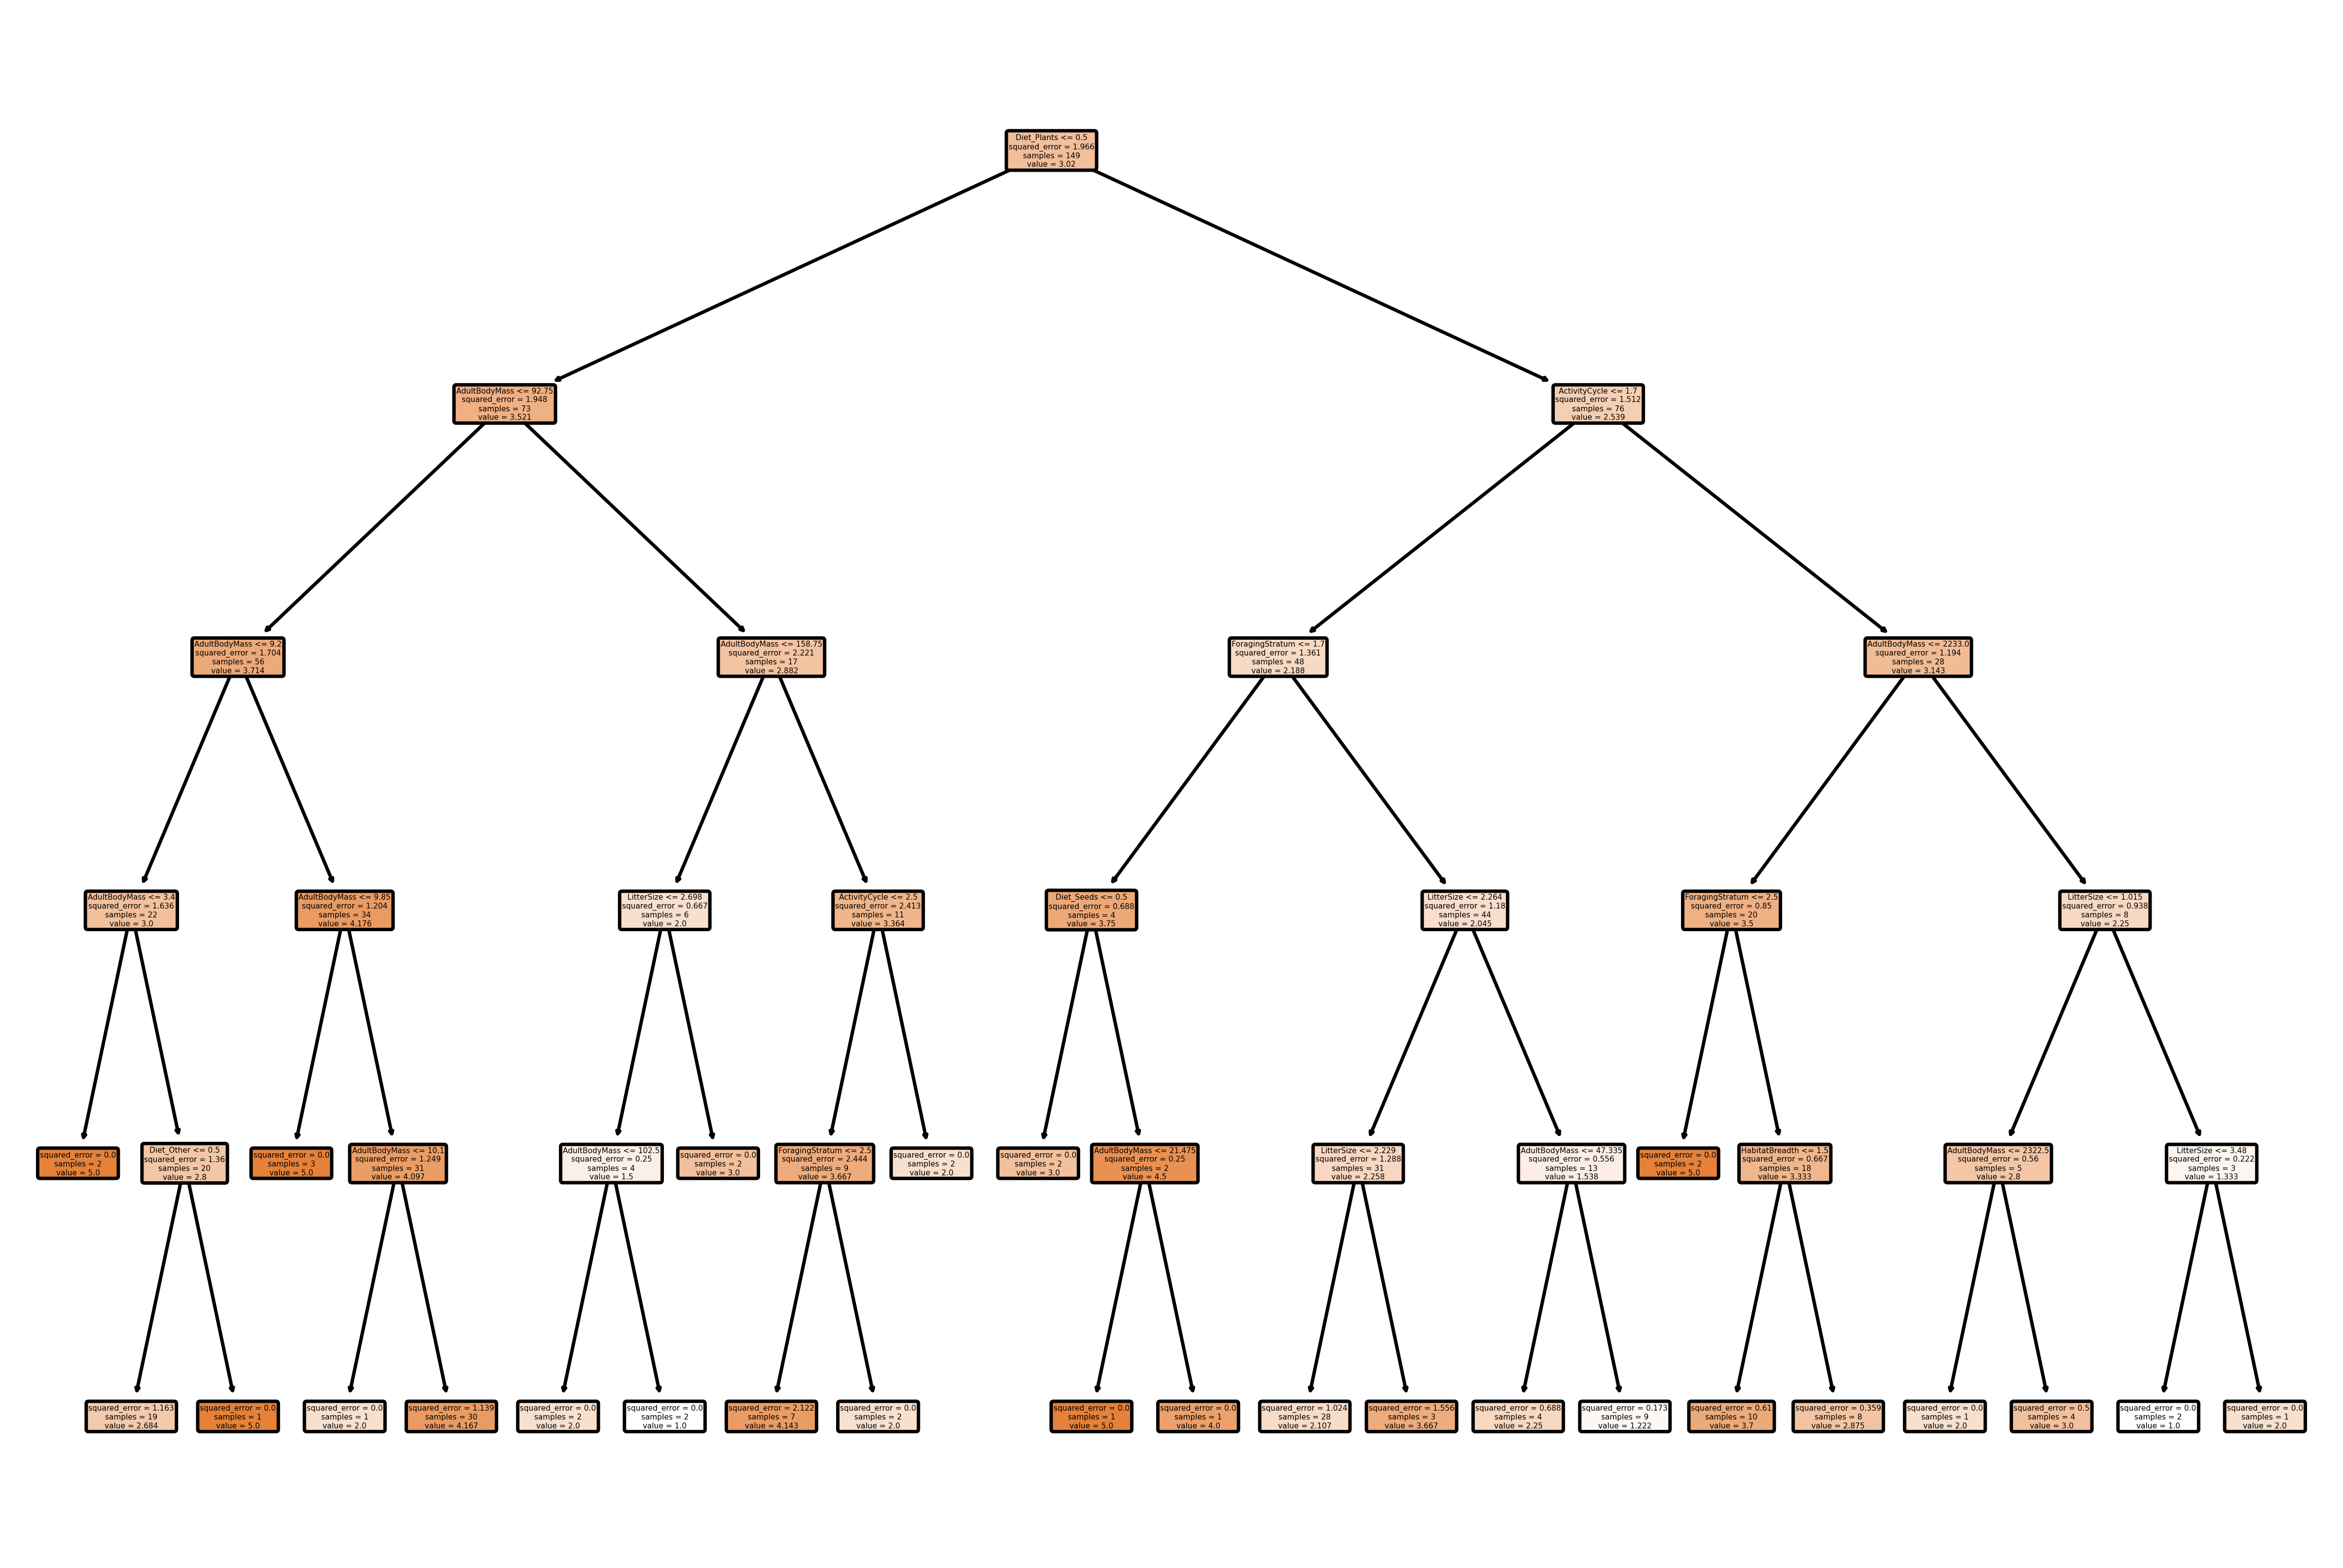

In [60]:
# Plot the decision tree
plt.figure(figsize=(12, 8), dpi=500)
plot_tree(DTR, feature_names=X.columns, filled=True, rounded=True)
plt.show()

Based on the way this tree looks, what would you guess the most important variable to be?

The most important variable type is Diet_Plants. This is because it is the root node in the tree, in which all future desicions are based off of.

### Step 5: Random forest with hyperparameter tuning
Now we'll use a more sophisticated ensemble approach where we optimize the values of key hyperparameters that govern tree growth.

- Define a parameter grid that includes the follow parameters and values:
  -  (sqrt(p), 6, and no set #) of the number of features to try at each split
  -  (50, 100, 200) total trees (learners)
  -  a maximum tree depth of (3,4,5,6,7)
  -  (2,5,10) minimum samples per split
  -  (1,2,4) minimum samples per leaf
  
- Use `GridSearchCV` with 5-fold cross-validation and mse (`neg_mean_squared_error`) to find the best combination of parameter values
- Train the best estimator.

In [61]:
# Define param grid
param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_features': ['sqrt', 6, None],  
    'max_depth': [3, 4, 5, 6, 7], 
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4] 
}

In [62]:
# Initialize Random Forest
rf = RandomForestRegressor(random_state=808)

# GridSeachCV 
gs = GridSearchCV(rf, 
                  param_grid=param_grid, 
                  n_jobs=-1, 
                  return_train_score=True, 
                  cv=5,
                  scoring='neg_mean_squared_error')

gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=808), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'max_features': ['sqrt', 6, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [63]:
# Get the best hyperparameter values
gs.best_params_

{'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 200}

### Step 6: Make predictions and evaluate random forest model
Use the optimized random forest model (`best_rf`) to predict the number of climates a species inhabits and analyze its performance.

- Use `best_rf` and `predict()` method on `X_test` to generate predictions
- Print the best set of parameter values using thte `best_params` method
- Compute and print the mse to evaluate model performance
- Extract feature importance from the trained random forest model
- Visualize feature importance using a bar plot

In [64]:
# Best parameters
best_params = gs.best_params_

print(f"Best params: {best_params}")

Best params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [65]:

best_rf = RandomForestRegressor(n_estimators=50, 
                                max_depth=7, 
                                max_features=6,
                                min_samples_leaf=1, 
                                min_samples_split=10)

best_rf.fit(X_train, y_train)

best_rf_preds = best_rf.predict(X_test)

In [66]:
mean_squared_error(y_test, best_rf_preds)

1.4519977203697256

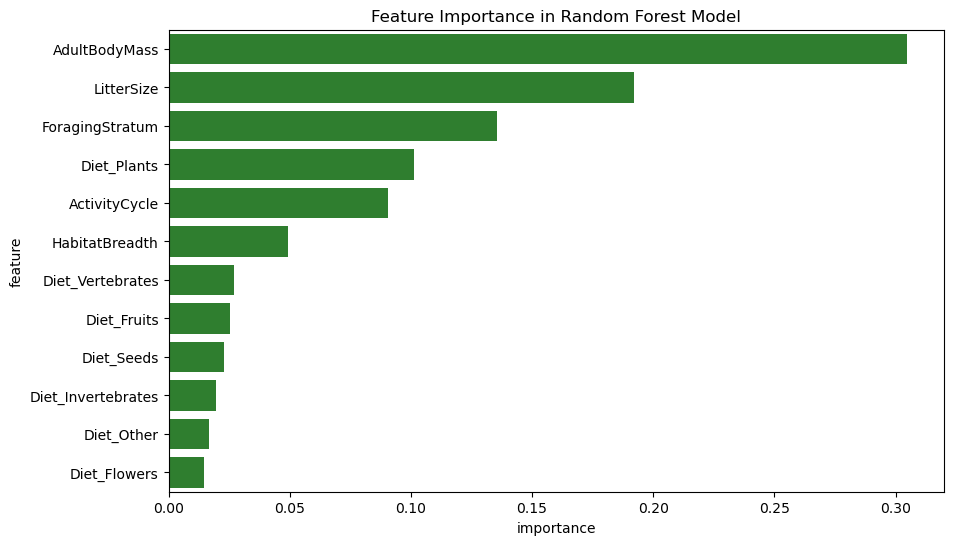

In [67]:
# Get feature importances
importances = best_rf.feature_importances_
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', color="forestgreen")
plt.title('Feature Importance in Random Forest Model')
plt.show()

Which model had better accuracy, the single tree or the ensemble.  Interpret which traits have the most influence on species' climate adaptability.

The ensemble had better accuracy, making the random forest model more optimized to our data than the decision tree. From the feature importance graph of the RF model, we see Litter Size and Adult Body Mass as the most important features to our model. This means that those with favorable characteristics of these traits will more likely be adaptable to climactic variance than those with more favorable characteristics of other traits, such as their diet.